# 03 SimpleCNN Training

PyTorch: 2.10.0+cu128
Torchvision: 0.25.0+cu128
Device: cuda
GPU disponibile: True


100%|██████████| 170M/170M [00:05<00:00, 32.0MB/s]


Training set: (50000, 32, 32, 3)
Test set: (10000, 32, 32, 3)
Range valori: [0, 255]
Classi: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


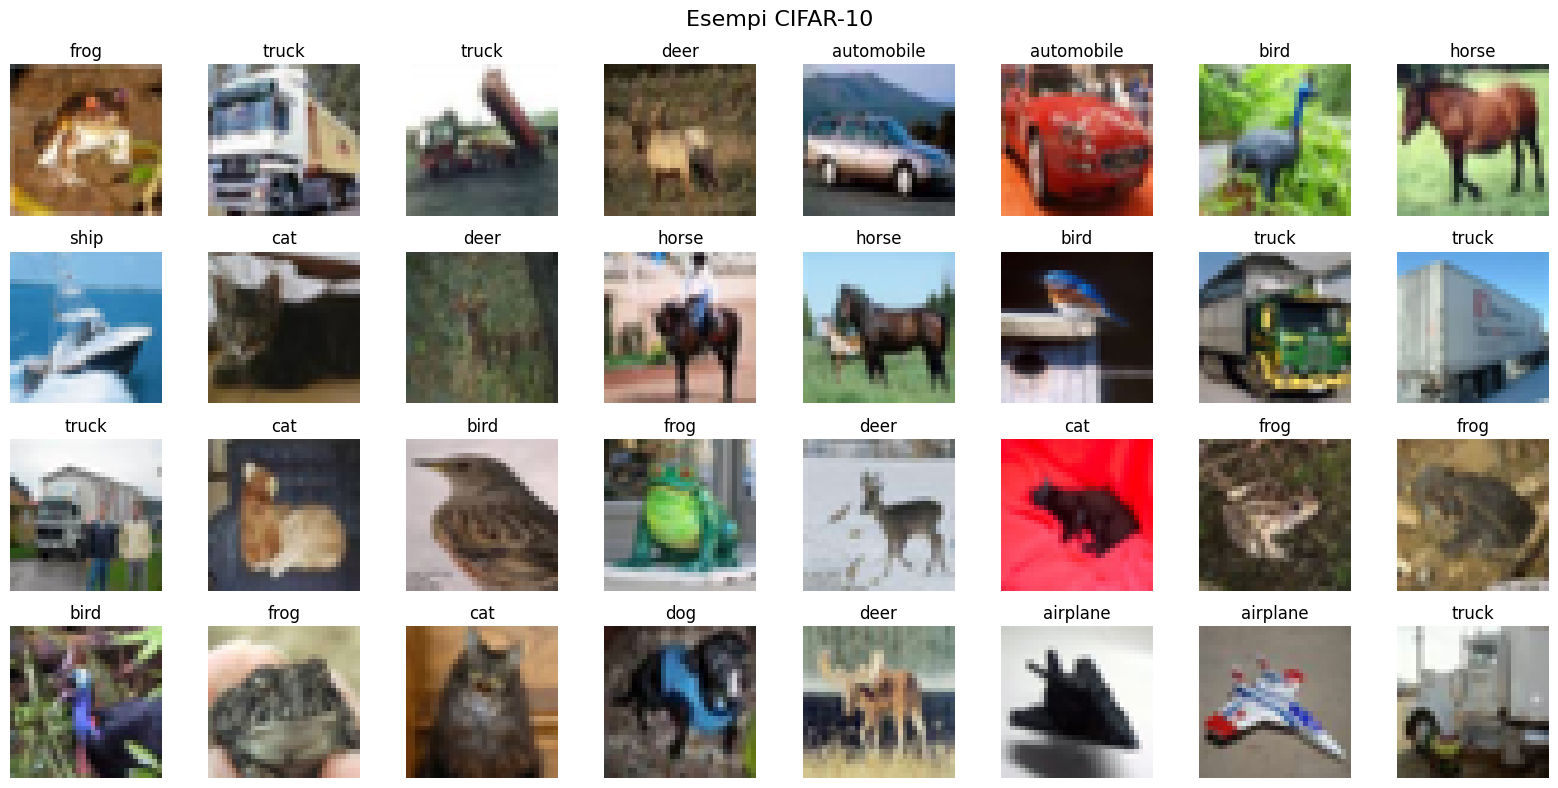

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"PyTorch: {torch.__version__}")
print(f"Torchvision: {torchvision.__version__}")
print(f"Device: {device}")
print(f"GPU disponibile: {torch.cuda.is_available()}")

# Caricamento CIFAR-10
transform_basic = transforms.ToTensor()

trainset_full = torchvision.datasets.CIFAR10(
    root='../data', train=True, download=True,
    transform=transform_basic
)
testset = torchvision.datasets.CIFAR10(
    root='../data', train=False, download=True,
    transform=transform_basic
)

# Per avere anche array numpy (utile per visualizzazioni)
trainset_raw = torchvision.datasets.CIFAR10(
    root='../data', train=True, download=True,
    transform=None
)
testset_raw = torchvision.datasets.CIFAR10(
    root='../data', train=False, download=True,
    transform=None
)

# Nomi classi CIFAR-10
class_names = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

# Estrai dati come numpy per preprocessing/visualizzazione
X_train = np.array([np.array(img) for img, _ in trainset_raw])
y_train = np.array([label for _, label in trainset_raw])
X_test = np.array([np.array(img) for img, _ in testset_raw])
y_test = np.array([label for _, label in testset_raw])

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"Range valori: [{X_train.min()}, {X_train.max()}]")
print(f"Classi: {class_names}")

# Visualizzazione esempi
fig, axes = plt.subplots(4, 8, figsize=(16, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i])
    ax.set_title(class_names[y_train[i]])
    ax.axis('off')
plt.suptitle('Esempi CIFAR-10', fontsize=16)
plt.tight_layout()
plt.show()

import os, urllib.request

# GitHub Release URL for pretrained weights (update with actual URL)
WEIGHTS_BASE_URL = os.environ.get('WEIGHTS_URL', 'https://github.com/SamueleBolotta/CEAR/releases/download/v1.0/')
WEIGHTS_DIR = '../pretrained_weights'
os.makedirs(WEIGHTS_DIR, exist_ok=True)

def load_or_train(model, train_fn, weights_filename, device='cpu'):
    """Load pretrained weights if available, otherwise train and save.
    Also saves/loads training history as JSON alongside weights."""
    weights_path = os.path.join(WEIGHTS_DIR, weights_filename)
    history_path = weights_path.replace('.pt', '_history.json')

    def _load_history():
        if os.path.exists(history_path):
            import json as _json
            with open(history_path, 'r') as f:
                return _json.load(f)
        return None

    if os.path.exists(weights_path):
        model.load_state_dict(torch.load(weights_path, map_location=device, weights_only=True))
        print(f"Loaded pretrained weights from {weights_path}")
        return _load_history()
    elif WEIGHTS_BASE_URL:
        try:
            url = WEIGHTS_BASE_URL + weights_filename
            urllib.request.urlretrieve(url, weights_path)
            try:
                urllib.request.urlretrieve(
                    WEIGHTS_BASE_URL + weights_filename.replace('.pt', '_history.json'), history_path)
            except Exception:
                pass
            model.load_state_dict(torch.load(weights_path, map_location=device, weights_only=True))
            print(f"Downloaded and loaded weights from {url}")
            return _load_history()
        except Exception as e:
            print(f"Could not download weights: {e}. Training from scratch...")

    history = train_fn()
    torch.save(model.state_dict(), weights_path)
    print(f"Saved weights to {weights_path}")
    if history is not None:
        import json as _json
        with open(history_path, 'w') as f:
            _json.dump(history, f)
        print(f"Saved training history to {history_path}")
    return history

In [2]:
# Normalizzazione a [0,1]
X_train_norm = X_train.astype('float32') / 255.0
X_test_norm = X_test.astype('float32') / 255.0

# Converti in tensori PyTorch (NCHW format)
X_train_tensor = torch.from_numpy(X_train_norm).permute(0, 3, 1, 2)  # NHWC -> NCHW
X_test_tensor = torch.from_numpy(X_test_norm).permute(0, 3, 1, 2)
y_train_tensor = torch.from_numpy(y_train).long()
y_test_tensor = torch.from_numpy(y_test).long()

print("Shape dopo preprocessing:")
print(f"  X_train tensor: {X_train_tensor.shape}")
print(f"  y_train tensor: {y_train_tensor.shape}")
print(f"Range valori: [{X_train_tensor.min():.2f}, {X_train_tensor.max():.2f}]")

Shape dopo preprocessing:
  X_train tensor: torch.Size([50000, 3, 32, 32])
  y_train tensor: torch.Size([50000])
Range valori: [0.00, 1.00]


---

## 3. Implementazione di una CNN

### 3.1 CNN Semplice

In [4]:
class SimpleCNN(nn.Module):
    """
    CNN semplice per CIFAR-10.
    """
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            # Primo blocco convoluzionale
            nn.Conv2d(3, 32, 3, padding=1),   # conv1
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                # pool1

            # Secondo blocco
            nn.Conv2d(32, 64, 3, padding=1),   # conv2
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                # pool2

            # Terzo blocco
            nn.Conv2d(64, 128, 3, padding=1),  # conv3
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),                # pool3
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 128),       # fc1
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)          # output (no softmax - CrossEntropyLoss handles it)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


# Creazione modello
model_simple = SimpleCNN().to(device)
print(model_simple)
total_params = sum(p.numel() for p in model_simple.parameters())
print(f"\nParametri totali: {total_params:,}")

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2048, out_features=128, bias=True)
    (2): ReLU()
    (3): Dropou

**Analisi dell'architettura:**

1. **Conv1**: 32x32x3 -> 32x32x32 (32 filtri 3x3)
2. **Pool1**: 32x32x32 -> 16x16x32 (riduzione dimensione spaziale)
3. **Conv2**: 16x16x32 -> 16x16x64 (64 filtri)
4. **Pool2**: 16x16x64 -> 8x8x64
5. **Conv3**: 8x8x64 -> 8x8x128 (128 filtri)
6. **Pool3**: 8x8x128 -> 4x4x128
7. **Flatten**: 4x4x128 = 2048 neuroni
8. **FC1**: 2048 -> 128
9. **Output**: 128 -> 10

### 3.2 Training

In [5]:
def train_model(model, train_loader, val_loader, epochs=5,
                lr=0.001, patience=5, patience_lr=3, device=device):
    """
    Training loop generico PyTorch con early stopping e ReduceLROnPlateau.
    Restituisce un dizionario con history (come Keras).
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=patience_lr, min_lr=1e-7
    )

    history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}
    best_val_loss = float('inf')
    best_model_state = None
    epochs_no_improve = 0

    for epoch in range(epochs):
        # Training
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / total
        train_acc = correct / total

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_loss = val_loss / val_total
        val_acc = val_correct / val_total

        scheduler.step(val_loss)

        history['loss'].append(train_loss)
        history['accuracy'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_accuracy'].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - "
              f"loss: {train_loss:.4f} - accuracy: {train_acc:.4f} - "
              f"val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.4f}")

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = {k: v.clone() for k, v in model.state_dict().items()}
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

    # Restore best weights
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return history


# Preparazione DataLoader con validation split
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
n_val = int(0.2 * len(train_dataset))
n_train = len(train_dataset) - n_val
train_subset, val_subset = random_split(
    train_dataset, [n_train, n_val],
    generator=torch.Generator().manual_seed(42)
)

train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=128, shuffle=False)

# Training (with weight caching)
history_simple = load_or_train(
    model_simple,
    lambda: train_model(
        model_simple, train_loader, val_loader,
        epochs=5, lr=0.001, patience=5, patience_lr=3
    ),
    'nb06_simple_cnn.pt',
    device=device
)


Downloaded and loaded weights from https://github.com/SamueleBolotta/CEAR/releases/download/v1.0/nb06_simple_cnn.pt


### 3.3 Valutazione

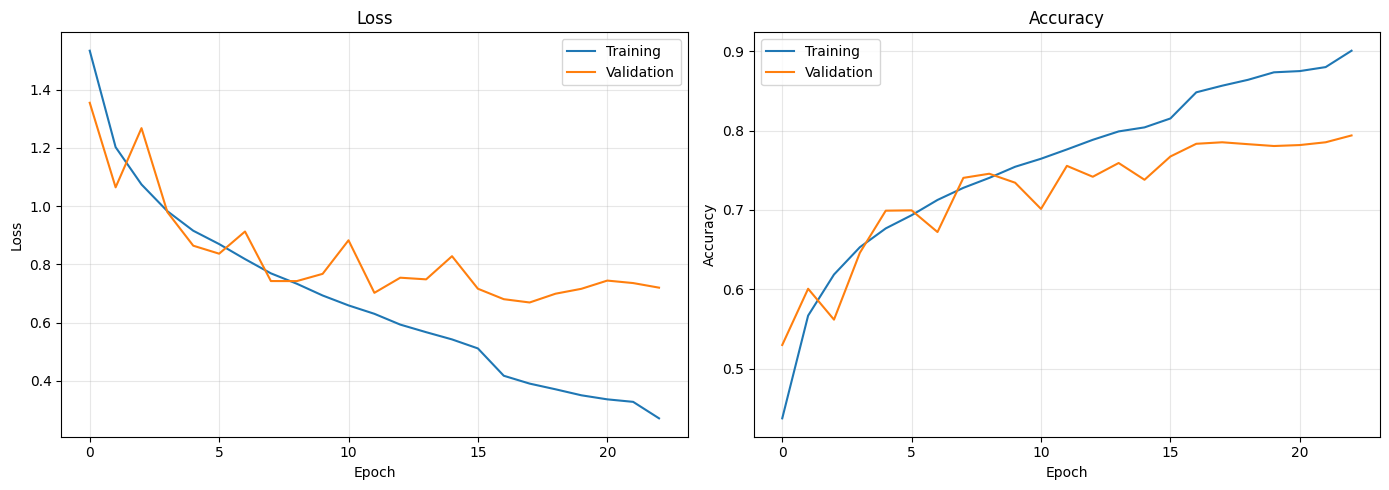

Test Loss: 0.6888
Test Accuracy: 0.7790

Classification Report:
              precision    recall  f1-score   support

    airplane       0.73      0.86      0.79      1000
  automobile       0.91      0.88      0.90      1000
        bird       0.63      0.74      0.68      1000
         cat       0.57      0.66      0.61      1000
        deer       0.80      0.75      0.77      1000
         dog       0.74      0.62      0.68      1000
        frog       0.91      0.76      0.83      1000
       horse       0.87      0.78      0.82      1000
        ship       0.88      0.87      0.87      1000
       truck       0.85      0.88      0.86      1000

    accuracy                           0.78     10000
   macro avg       0.79      0.78      0.78     10000
weighted avg       0.79      0.78      0.78     10000



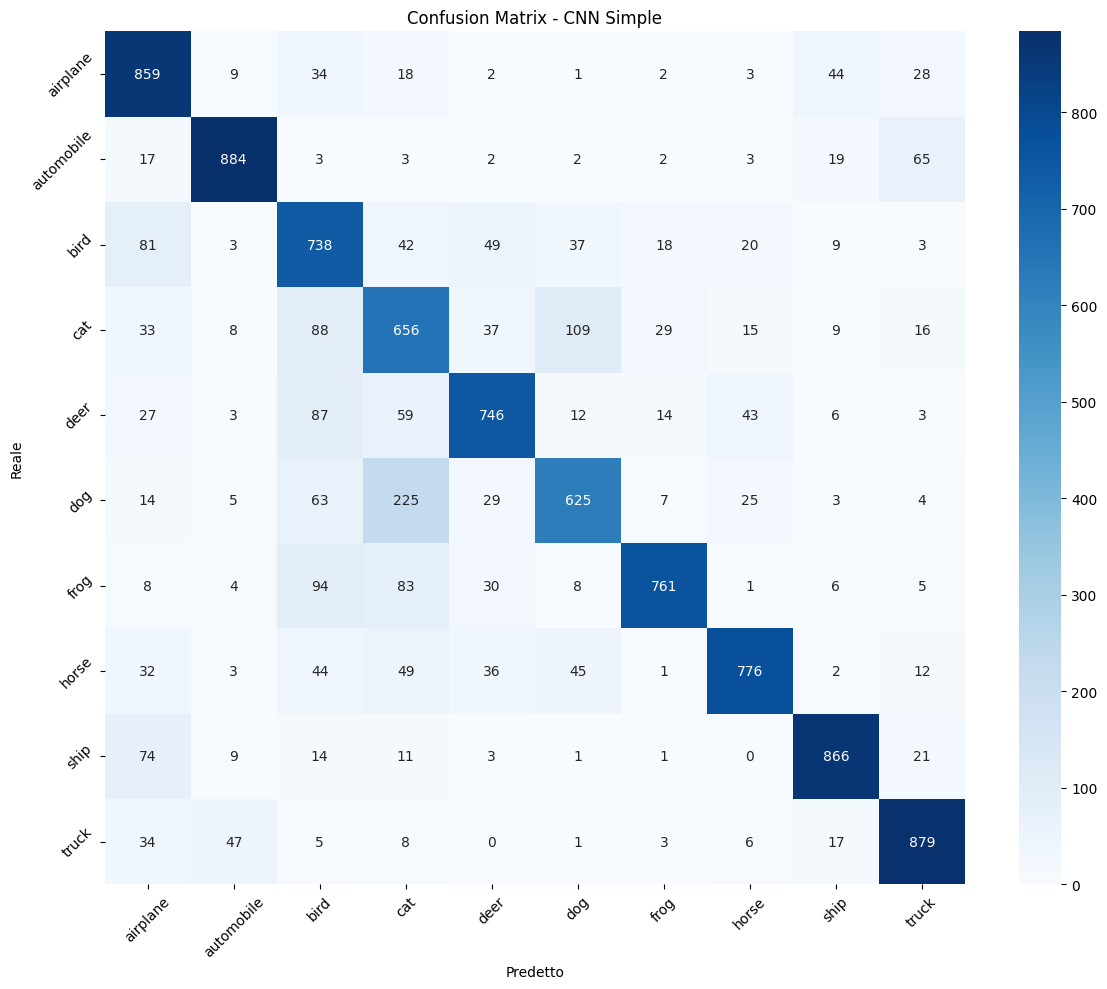

In [6]:
# Plot learning curves
if history_simple is not None:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    axes[0].plot(history_simple['loss'], label='Training')
    axes[0].plot(history_simple['val_loss'], label='Validation')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Loss')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    axes[1].plot(history_simple['accuracy'], label='Training')
    axes[1].plot(history_simple['val_accuracy'], label='Validation')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Accuracy')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print("Using pretrained weights - training curves not available")

# Valutazione test set
def evaluate_model(model, X_tensor, y_tensor, device=device):
    """Evaluate model and return loss, accuracy, predictions."""
    model.eval()
    test_dataset = TensorDataset(X_tensor, y_tensor)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
    criterion = nn.CrossEntropyLoss()

    test_loss = 0.0
    correct = 0
    total = 0
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            all_preds.append(predicted.cpu())
            all_probs.append(probs.cpu())

    test_loss = test_loss / total
    test_acc = correct / total
    all_preds = torch.cat(all_preds).numpy()
    all_probs = torch.cat(all_probs).numpy()
    return test_loss, test_acc, all_preds, all_probs


test_loss, test_acc, y_pred, y_pred_proba = evaluate_model(
    model_simple, X_test_tensor, y_test_tensor
)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(
    y_test, y_pred, target_names=class_names
))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel('Predetto')
plt.ylabel('Reale')
plt.title('Confusion Matrix - CNN Simple')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()
